In [4]:
!pip install kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"spideyy1122","key":"c15fc58352d2422295745896a4ec4fcb"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 148M/149M [00:04<00:00, 42.5MB/s]
100% 149M/149M [00:04<00:00, 36.4MB/s]


In [8]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [10]:
!ls

brain-tumor-mri-dataset.zip  kaggle.json  sample_data  Testing	Training


In [15]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [21]:
# Define paths to your dataset (update these paths if needed)
base_dir = '/content'  # Adjust based on extracted folder structure
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Create a DataFrame for the dataset
def create_dataframe(directory):
    imagepaths = []
    labels = []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for img in os.listdir(class_dir):
                imagepaths.append(os.path.join(class_dir, img))
                labels.append(label)
    return pd.DataFrame({'imagepaths': imagepaths, 'labels': labels})

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

# Split the training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.15, stratify=train_df['labels'], random_state=123)


In [23]:

# Display the sizes of the resulting DataFrames
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 4855
Validation set size: 857
Test set size: 1311


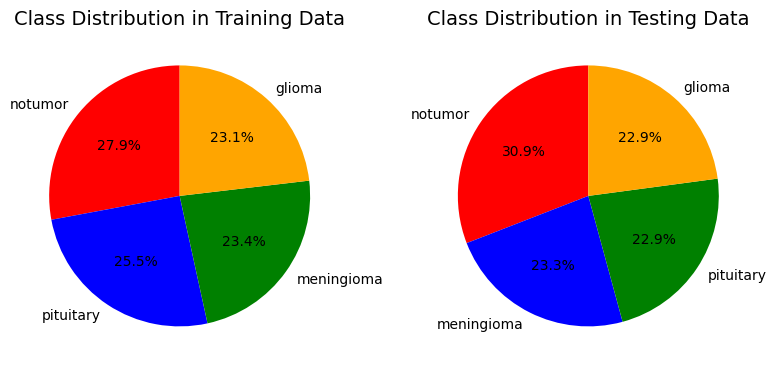

In [24]:
# Analyze class distribution in the training and testing sets
train_class_counts = train_df['labels'].value_counts()
test_class_counts = test_df['labels'].value_counts()

# Define colors for the pie chart
colors = ["red", "blue", "green", "orange"]  # Corresponding to glioma, meningioma, notumor, pituitary

# Create a figure with two subplots arranged horizontally
fig, axes = plt.subplots(1, 2, figsize=(8, 6))  # 1 row, 2 columns

# Plot pie chart for training data
axes[0].pie(train_class_counts, labels=train_class_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
axes[0].set_title('Class Distribution in Training Data', fontsize=14)

# Plot pie chart for testing data
axes[1].pie(test_class_counts, labels=test_class_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Class Distribution in Testing Data', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [25]:
img_size = (256, 256)  # Input size for ResNet50V2
batch_size = 32

tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col="imagepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True
)

# Validation data generator
valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col="imagepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True
)

# Testing data generator
test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col="imagepaths",
    y_col="labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False
)

Found 4855 validated image filenames belonging to 4 classes.
Found 857 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [26]:
class_count = 4  # Number of classes in the dataset
img_shape = (256, 256, 3)

# Pre-trained ResNet50V2 model
base_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape
)

# Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(2048, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 8, 8, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,548,868 (116.53 MB)

 Trainable params: 6,984,068 (26.64 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
epochs = 50
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 130s 719ms/step - accuracy: 0.3347 - loss: 43.3844 - val_accuracy: 0.6896 - val_loss: 32.5357 - learning_rate: 1.0000e-04
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 87s 571ms/step - accuracy: 0.6465 - loss: 30.1833 - val_accuracy: 0.8016 - val_loss: 23.8311 - learning_rate: 1.0000e-04
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 85s 560ms/step - accuracy: 0.7675 - loss: 22.3842 - val_accuracy: 0.8366 - val_loss: 18.3601 - learning_rate: 1.0000e-04
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 86s 568ms/step - accuracy: 0.8209 - loss: 17.3913 - val_accuracy: 0.8600 - val_loss: 14.5475 - learning_rate: 1.0000e-04
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 86s 566ms/step - accuracy: 0.8406 - loss: 13.8414 - val_accuracy: 0.8786 - val_loss: 11.6923 - learning_rate: 1.0000e-04
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 85s 561ms/step - accuracy: 0.8486 - loss: 11.1642 - val_accuracy: 0.8705 - val_loss: 9.5092 - learning_rate: 1.0000e-04
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━

In [28]:
train_score = model.evaluate(train_gen, verbose=0)
valid_score = model.evaluate(valid_gen, verbose=0)
test_score = model.evaluate(test_gen, verbose=0)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

Train Loss:  0.44432714581489563
Train Accuracy:  0.9373841285705566
--------------------
Validation Loss:  0.48844456672668457
Validation Accuracy:  0.9159860014915466
--------------------
Test Loss:  0.5351821184158325
Test Accuracy:  0.9023646116256714


In [29]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)  # Convert probabilities to class labels
y_true = test_gen.classes  # True labels
labels = list(test_gen.class_indices.keys())

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 282ms/step


In [30]:
from sklearn.metrics import classification_report

clr = classification_report(
    y_true,       # True labels
    y_pred,       # Predicted labels
    target_names=labels  # Class names
)

print("Classification Report:")
print(clr)

Classification Report:
              precision    recall  f1-score   support

      glioma       0.93      0.81      0.87       300
  meningioma       0.81      0.81      0.81       306
     notumor       0.94      0.98      0.96       405
   pituitary       0.92      0.98      0.95       300

    accuracy                           0.90      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.90      0.90      0.90      1311



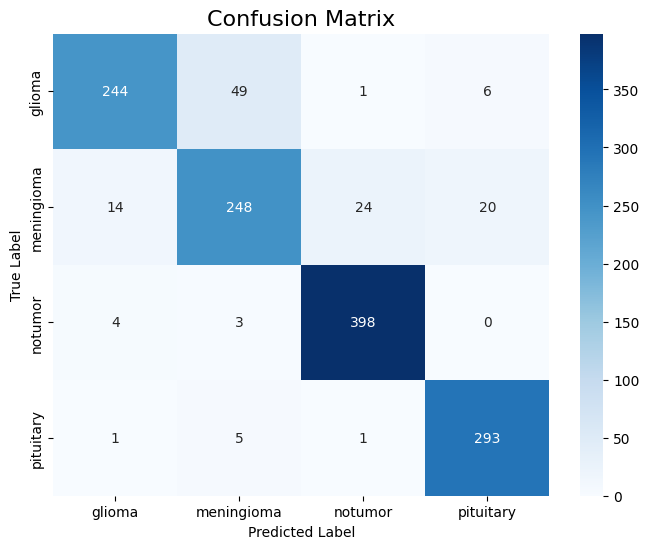

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_true, preds, multi_class='ovr')  # One-vs-Rest strategy
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9824


In [33]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")

Cohen's Kappa Score: 0.8688


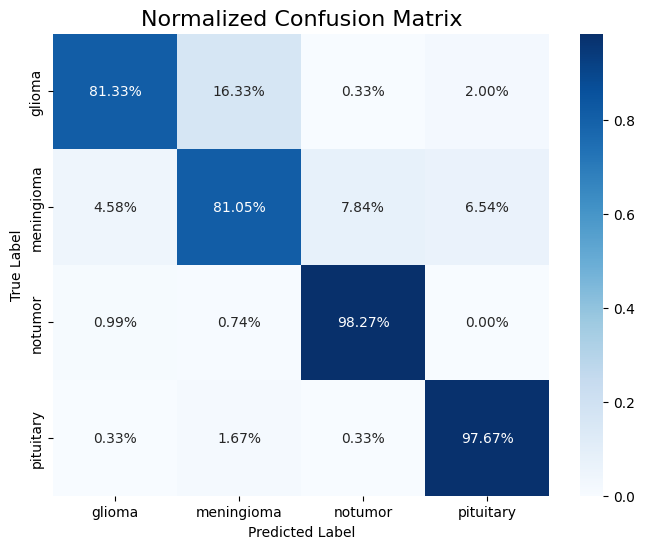

In [34]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.show()

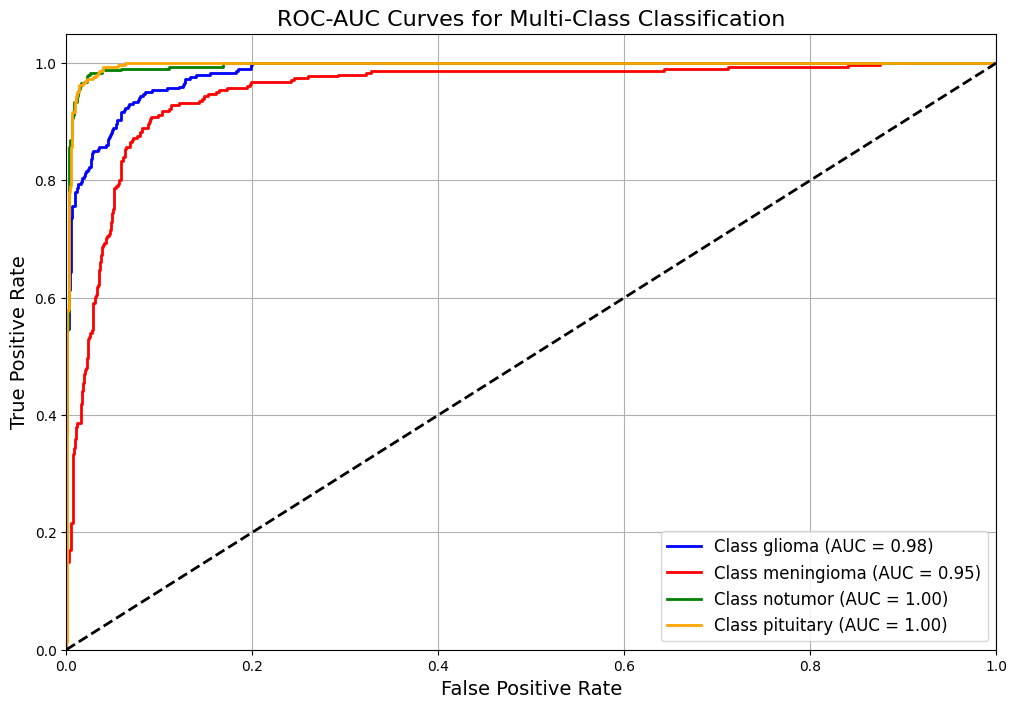

In [35]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
n_classes = y_true_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC-AUC Curves for Multi-Class Classification', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

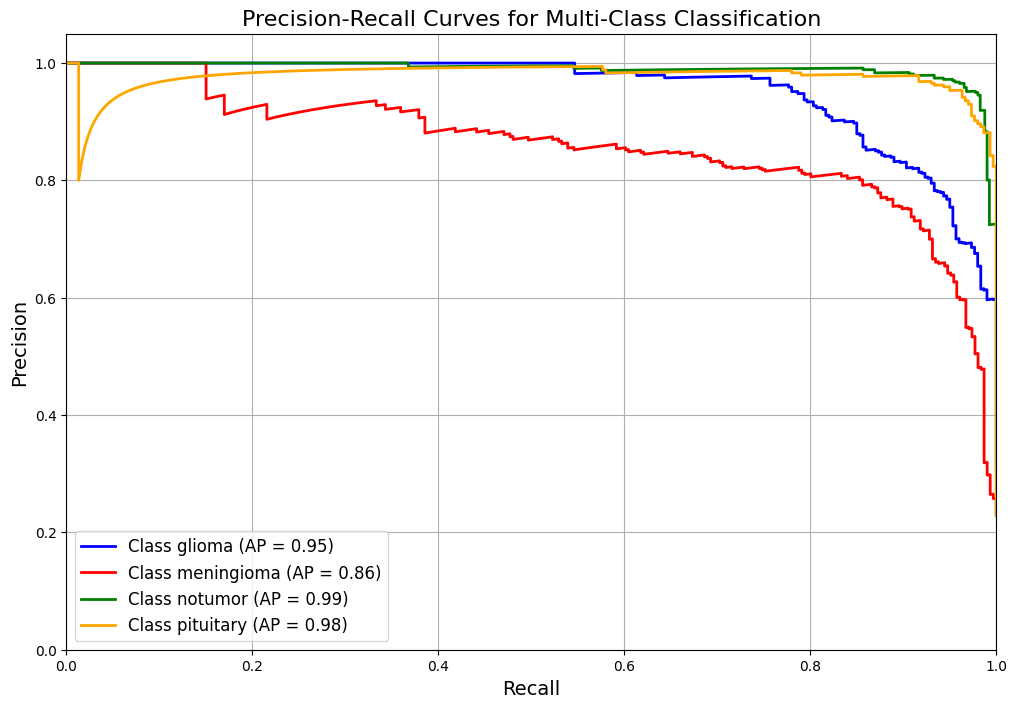

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], preds[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], preds[:, i])

plt.figure(figsize=(12, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {labels[i]} (AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves for Multi-Class Classification', fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True)
plt.show()

In [38]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


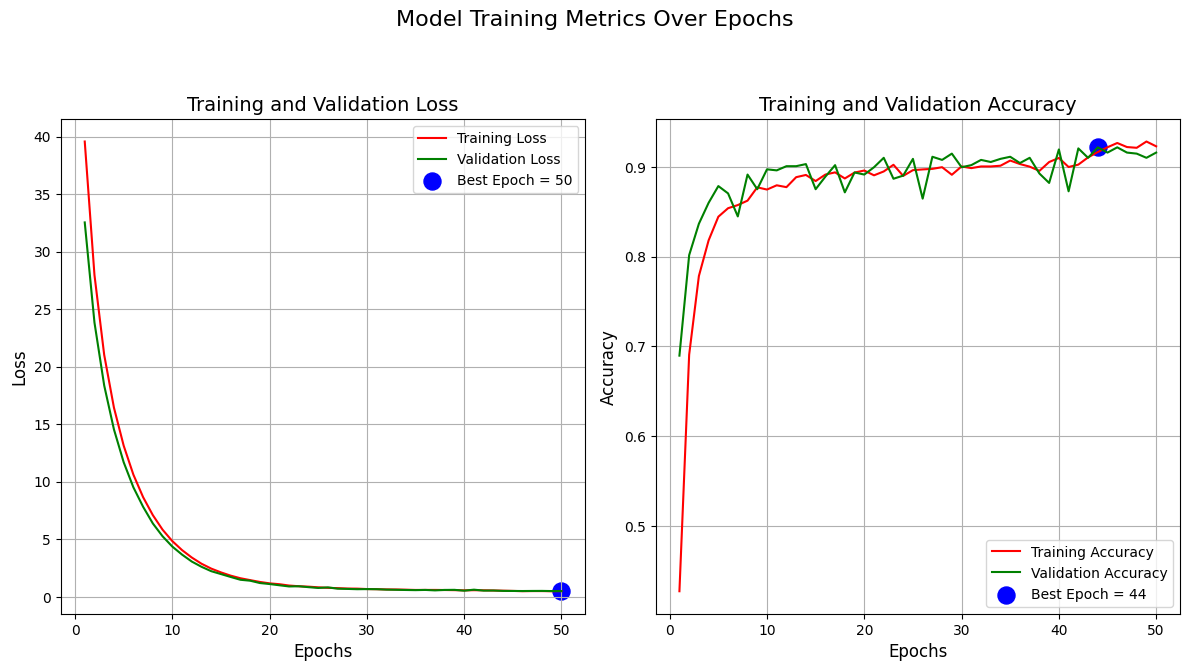

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Extract metrics from the training history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Create a list of epochs for plotting
epochs_range = range(1, len(tr_acc) + 1)

# Find the best epoch for each metric
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Plot the metrics
plt.figure(figsize=(12, 12))

# Subplot 1: Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, tr_loss, 'r', label='Training Loss')
plt.plot(epochs_range, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=f'Best Epoch = {index_loss + 1}')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Subplot 2: Training and Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, tr_acc, 'r', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=f'Best Epoch = {index_acc + 1}')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Add a title for the entire figure
plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

In [44]:
def predict_fixed(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

    # Extract the true class from the folder name
    true_class = os.path.basename(os.path.dirname(img_path))

    # Load correct class indices from train_gen
    label = {v: k for k, v in train_gen.class_indices.items()}

    # Load the image
    img = Image.open(img_path).convert('RGB')
    resized_img = img.resize((256, 256))  # Resize to match ResNet50V2 input size
    img_array = np.asarray(resized_img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image (if required)

    # Generate predictions
    predictions = model.predict(img_array)
    predicted_class = label[np.argmax(predictions[0])]

    # Plot the image with class labels
    plt.figure(figsize=(6, 6))
    plt.imshow(resized_img)
    plt.axis('off')

    # Add text annotations for original and predicted class
    plt.text(10, 20, f"Original: {true_class}", color="yellow", fontsize=14, bbox=dict(facecolor='black', alpha=0.7))
    plt.text(10, 50, f"Predicted: {predicted_class}", color="cyan", fontsize=14, bbox=dict(facecolor='black', alpha=0.7))

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


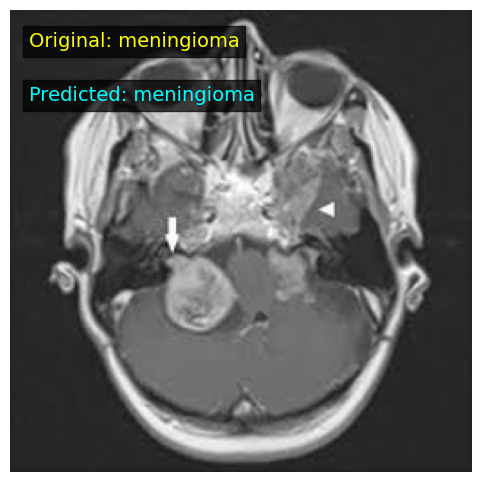

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


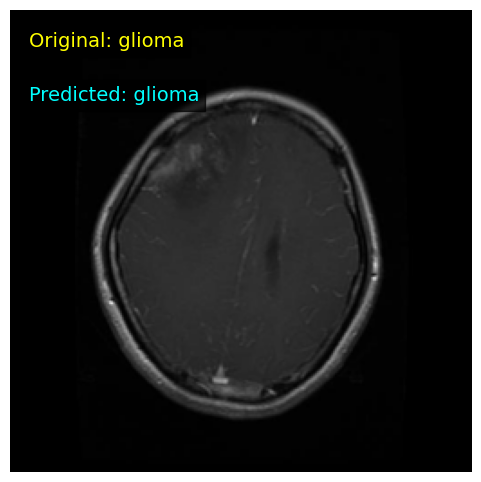

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


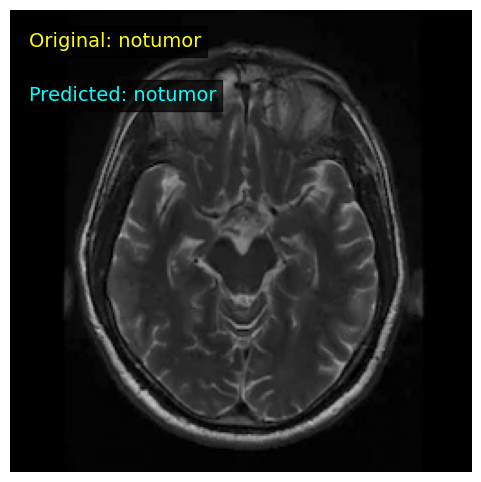

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


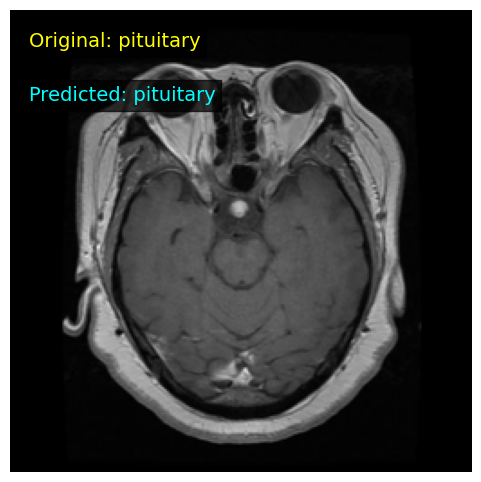

In [45]:

# Test the function with sample MRI images
predict_fixed('/content/Testing/meningioma/Te-meTr_0002.jpg')
predict_fixed('/content/Testing/glioma/Te-glTr_0002.jpg')
predict_fixed('/content/Testing/notumor/Te-noTr_0006.jpg')
predict_fixed('/content/Testing/pituitary/Te-pi_0010.jpg')